In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import collections
import os
import gensim 
import matplotlib.pyplot as pt
%matplotlib inline
import scipy
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
from nltk import pos_tag
# from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn import model_selection, naive_bayes, svm
# from sklearn.metrics import accuracy_score
for dirname, _, filenames in os.walk('/Users/Yassi/Documents/CS221/project'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/Users/Yassi/Documents/CS221/project/Event0_TSNE_500.png
/Users/Yassi/Documents/CS221/project/progress.pdf
/Users/Yassi/Documents/CS221/project/error_SVM_Word2Vec_eta0p01_l0p01_bs512_L1.png
/Users/Yassi/Documents/CS221/project/.DS_Store
/Users/Yassi/Documents/CS221/project/error_SVM_Word2Vec_eta0p01_l0p01_bs512_L2.png
/Users/Yassi/Documents/CS221/project/error_SVM_Word2Vec_eta0p01_l0p01_bs512_L2_wAgeSex.png
/Users/Yassi/Documents/CS221/project/Event44_TSNE_500.png
/Users/Yassi/Documents/CS221/project/CDC.key
/Users/Yassi/Documents/CS221/project/loss_LR_WordNet_eta0p01_l0p01_bs512_L2_nf1000_wAgeSex.png
/Users/Yassi/Documents/CS221/project/error_SVM_Word2Vec_eta0p01_l0p01_bs512_L1_wAgeSex.png
/Users/Yassi/Documents/CS221/project/Logistic+Regression+with+a+Neural+Network+mindset+v5.ipynb
/Users/Yassi/Documents/CS221/project/error_SVM_BoW_eta0p01_l0p01_bs512_L2.png
/Users/Yassi/Documents/CS221/project/error_SVM_Word2Vec_eta0p01_l0p001_bs512_L2.png
/Users/Yassi/Documents/CS221/project/progr

In [2]:
data_train = pd.read_csv('/Users/Yassi/Documents/CS221/project/data/train.csv')
data_train.head()

,text,sex,age,event
0,57YOM WITH CONTUSION TO FACE AFTER STRIKING IT...,1,57,62
1,A 45YOM FELL ON ARM WHILE WORKING HAD SLIPPED ...,1,45,42
2,58YOM WITH CERVICAL STRAIN BACK PAIN S P REST...,1,58,26
3,33 YOM LAC TO HAND FROM A RAZOR KNIFE,1,33,60
4,53YOM AT WORK IN A WAREHOUSE DOING UNSPECIFIED...,1,53,71


In [3]:
reps = []
reps.append(('LACERATION','LAC'))
reps.append(('RIGHT','R','RT'))
reps.append(('LEFT','L','LT'))
reps.append(('LARGE','LG'))
# reps.append(('W','WITH'))
# reps.append(('W O','WITHOUT'))
reps.append(('FRACTURE','FX',))
# reps.append(('FB','FOREIGN BODY'))

unused_words  =['YOM','YOF','','WITH','AND','WORK','WAS','WHILE','WHEN',
                'THE','YET','PAIN','FROM','THEY','GET','IF','INTO','UNTO',
                'FOR','ALSO','HE','PT','BY','IT','AN','DAYS','WHO','FORCED',
                'SHE','THAT','MALE','HAD','UPON','SUBJECT','PATIENT','FEMALE',
                'HAS','HIM','HER','HIS','WORKING','AFTER','DX','FALL','AGO',
                'TODAY','AND','IS','OF','YO','IN','ON','AS','AT','TO','NOW',
                'MS','THIS','SOME','YF','YM','OR','NOT']


In [4]:
def word_reps(word):
    for group in reps:
        if word in group:
            print(group)
word_reps('L')

('LEFT', 'L', 'LT')


In [5]:
def ExctractFeatures(x,unused_words):
    """
    Extract word features given string x. words are deliminated with white spaces. 
    Words with different representations are only saved into one feature. For example
    'LACERATION' is also written as 'LAC' in some descriptions. For more information please refer to 
    function word_reps(word)
    @param x : string for each case
    @return dictionary of features (sparse dict)
    
    """
    
    words = x.split(' ')
    phi = collections.defaultdict(float)
    for token in words: 
        added = False
        for group in reps:
            if token in group:
                phi[group[0]] += 1
                added = True
            
            
            
        if not added:
            if token not in unused_words and len(token) > 1:
                if 'YO' not in token and 'YF' not in token and 'YM' not in token:
                    if not token.isdigit():
                        phi[token] += 1
    return phi

In [133]:
#synthesizing data
# import nltk
# nltk.download('wordnet')
import copy 
corpus_aug = copy.deepcopy(corpus)

aug_event = collections.defaultdict(int) 
aug_data_event = []
aug_data = []
for e,sentence in enumerate(corpus):
    for i,token in enumerate(sentence):
        if event[data_train['event'][e]] < 300:
#             if token in wn.synsets:
            if len(wn.synsets(token)) > 1:
                w = wn.synsets(token)[0].name().split('.')[0].upper()
                if w != token:
                    new_sentence = sentence[0:i]+[w]+sentence[i+1:]
                    aug_data.append(new_sentence)
                    corpus_aug.append(new_sentence)
                    aug_data_event.append(data_train['event'][e])
                    aug_event[data_train['event'][e]] += 1


In [6]:
#making test and train sets

####################PARAMETERS#################
wMatrixSize = 1000
MinCount = 100
BoW = False
numWindows = 5
#####################

In [8]:
corpus = []
words = collections.defaultdict(float)
for index,row in data_train.iterrows():
    phi = ExctractFeatures(row['text'],unused_words)
    t =[]
    for f in phi.keys():
        t.append(f)
        words[f] += 1
    corpus.append(t)
event = collections.defaultdict(int)    
for e in data_train['event']:
    event[e] += 1
EVENT = sorted(event.items(), key=lambda kv: kv[1],reverse=True)
SORTED_WORD_VEC = sorted(words.items(), key=lambda kv: kv[1],reverse=True)
event_to_index = {events[0]:i for i,events in enumerate(EVENT)}
word_to_event = defaultdict(set)
event_to_word = defaultdict(set)
for i,group in enumerate(corpus):
    token_sorted = sorted(group, key = lambda x: words[x],reverse=True)
    for token in token_sorted:
        word_to_event[token].add(data_train['event'][i])
        event_to_word[data_train['event'][i]].add(token)

if BoW==True:
    model = Word2Vec(corpus, min_count = MinCount,  
                                  size = wMatrixSize, window =numWindows)

    X= np.array([np.mean([model.wv[word] for word in lines if word in model.wv.vocab] or [np.zeros(wMatrixSize)], axis=0) 
                            for lines in corpus])
    # X = vectorizer.fit_transform(corpus)

In [134]:
model = Word2Vec(corpus_aug, min_count = MinCount,  
                                  size = wMatrixSize, window =numWindows)

X_aug= np.array([np.mean([model.wv[word] for word in lines if word in model.wv.vocab] or [np.zeros(wMatrixSize)], axis=0) 
                            for lines in corpus_aug])

In [144]:
y = []
for i in range(len(corpus)):
    y.append(event_to_index[data_train['event'][i]])
for i in range(len(aug_data)):
    y.append(event_to_index[aug_data_event[i]])
    
Y = np.eye(len(EVENT))[y]

In [146]:
y_category = defaultdict(list)
x_category = defaultdict(list)
for j in range(len(corpus_aug)):
    y_category[y[j]].append([j]) 
#     print(X[j])
    x_category[y[j]].append(X_aug[j])
#     x_category[y[j]].append(X[j])
#     print(len(x_category[y[j]]))



In [147]:
X_train = np.array([]).reshape((0,wMatrixSize))
X_dev = np.array([]).reshape((0,wMatrixSize))

y_train = np.array([]).reshape((0,1))
y_dev = np.array([]).reshape((0,1))

for e in y_category.keys():
    Nreps = int(len(x_category[e]))
    if Nreps >= 10:
        X_train = np.append(X_train,x_category[e][0:int(Nreps*0.9)],axis=0)
        y_train= np.append(y_train,np.array([e]*int(len(y_category[e][0:int(Nreps*0.9)]))).reshape(int(len(y_category[e][0:int(Nreps*0.9)])),1),axis=0)
        
        X_dev = np.append(X_dev,x_category[e][int(Nreps*0.9):],axis=0)
        y_dev= np.append(y_dev,np.array([e]*(int(len(y_category[e]))-int(Nreps*0.9))).reshape(int(len(y_category[e]))-int(Nreps*0.9),1),axis=0)
    else:
        X_train = np.append(X_train,x_category[e],axis=0)
        y_train= np.append(y_train,np.array([e]*int(len(y_category[e]))).reshape(int(len(y_category[e])),1),axis=0)



In [107]:
Y_train = np.eye(len(EVENT))[y_train.astype(int)]
Y_dev = np.eye(len(EVENT))[y_dev.astype(int)]


In [10]:
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
# import nltk
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
final = []
for index,entry in enumerate(corpus):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    final.append(str(Final_words))
# final

Tfidf_vect = TfidfVectorizer(max_features=wMatrixSize)
Tfidf_vect.fit(final)
Train_X_Tfidf = Tfidf_vect.transform(final)
Train_X_Tfidf = scipy.sparse.csr_matrix.todense(Train_X_Tfidf)

In [33]:
y_category = defaultdict(list)
x_category = defaultdict(list)
for j in range(len(corpus)):
    y_category[y[j]].append([j]) 
    x_category[y[j]].append(Train_X_Tfidf[j])

X_train = np.array([]).reshape((0,wMatrixSize))
X_dev = np.array([]).reshape((0,wMatrixSize))

y_train = np.array([]).reshape((0,1))
y_dev = np.array([]).reshape((0,1))

for e in y_category.keys():
    Nreps = int(len(x_category[e]))
    if Nreps >= 10:
        X_train = np.append(X_train,np.squeeze(np.array(x_category[e][0:int(Nreps*0.9)]),axis=1),axis=0)
        y_train= np.append(y_train,np.array([e]*int(len(y_category[e][0:int(Nreps*0.9)]))).reshape(int(len(y_category[e][0:int(Nreps*0.9)])),1),axis=0)
        
        X_dev = np.append(X_dev,np.squeeze(np.array(x_category[e][int(Nreps*0.9):]),axis=1),axis=0)
        y_dev= np.append(y_dev,np.array([e]*(int(len(y_category[e]))-int(Nreps*0.9))).reshape(int(len(y_category[e]))-int(Nreps*0.9),1),axis=0)
    else:
        X_train = np.append(X_train,np.squeeze(np.array(x_category[e]),axis=1),axis=0)
        y_train= np.append(y_train,np.array([e]*int(len(y_category[e]))).reshape(int(len(y_category[e])),1),axis=0)


In [57]:
# print(Train_X_Tfidf.shape)
X_train_extended=[]
for i in range(X_train.shape[0]):
    age_category = int(data_train['age'][i]/20)
    X_train_extended.append(np.concatenate((X_train[i],[age_category]),axis=0))

X_train_extended = np.squeeze(np.array(X_train_extended))

X_dev_extended=[]
for i in range(X_dev.shape[0]):
    age_category = int(data_train['age'][i+X_train.shape[0]]/20)
    X_dev_extended.append(np.concatenate((X_dev[i],[age_category]),axis=0))

X_dev_extended = np.squeeze(np.array(X_dev_extended))


In [100]:
# print(Train_X_Tfidf.shape)
X_train_extended=[]
for i in range(X_train.shape[0]):
    age_category = int(data_train['age'][i]/20)
    X_train_extended.append(np.concatenate(([1],X_train[i]),axis=0))

X_train_extended = np.squeeze(np.array(X_train_extended))

X_dev_extended=[]
for i in range(X_dev.shape[0]):
    age_category = int(data_train['age'][i+X_train.shape[0]]/20)
    X_dev_extended.append(np.concatenate(([1],X_dev[i]),axis=0))

X_dev_extended = np.squeeze(np.array(X_dev_extended))




In [148]:
def UpdateWeightsSVM(parameters,y,X,eta,l):
    """
    Updates the parameters based on prediction
    
    @param parameters : a dictionary with keys W and b
    @param eta : step size
    @param l : regularization constant 
    @param y : vector of true Y with size [batch_size, 1]
    @param X : feature vector [bathc_size, Word matrix Size]
    @param predicted_Y : one-hot vector of predicted Y [number of class classification,batch size]
    
    @retrun updated W and b in parameters dictionary
    """
    W = parameters["W"]

    scores = np.dot(X,W.T)
    yi_scores = scores[np.arange(scores.shape[0]),y.T]
#     print(yi_scores.shape)
    margins = np.maximum(0, scores - yi_scores.T+ 1)
    margins[np.arange(X.shape[0]),y.T] = 0
    loss = np.mean(np.sum(margins, axis=1))
    loss += 0.5*l* np.sum(np.dot(W.T,W))
#     loss += l* np.sum(np.abs(W))
    
    binary = margins
    binary[margins > 0] = 1
    row_sum = np.sum(binary, axis=1)
    binary[np.arange(X.shape[0]),y.T] = -row_sum.T
    dW = np.dot(binary.T,X)

    # Average
    dW /= y.shape[0]

    # Regularize
#     dW += l*W
    
    dW += l*((W>=0)*1.0+(W<0)*-1.0)

    W -= eta*dW

    
    parameters = {"W" : W}
    
    return parameters,loss
 




In [149]:
def LossSVM(X,Y,W,l):
    


    scores = np.dot(X,W.T)
    yi_scores = scores[np.arange(scores.shape[0]),Y.T] 
    margins = np.maximum(0, scores - yi_scores.T+ 1)
    margins[np.arange(X.shape[0]),Y.T] = 0
    loss = np.mean(np.sum(margins, axis=1))
    loss += 0.5*l* np.sum(np.dot(W.T,W))
#     loss += l* np.sum(np.abs(W))
    
#     print('loss : ',loss)
    return loss

In [150]:
def PredictionAccuracySVM(X,Y,parameters):
    """
    
    
    """
    W = parameters["W"]
    Z = np.zeros(Y.shape)
    errorM = 0
    Z= np.dot(W,X.T)
#     print(W)
    freq = np.zeros((48,1))
    error = np.zeros((48,1))
    for i in range(Y.shape[0]):
        freq[Y[i]] += 1
        if np.argmax(Z[:,i]) != Y[i]:
            error[Y[i]] += 1
            errorM += 1
    print("error :",error/(freq+0.001))
    print("avergae error :",errorM/Y.shape[0])
#     print(error/Y.shape[0])
    return error/(freq+0.001)
#     return error/Y.shape[0]

In [151]:
def InitializeParametersSVM(m,n_x,batch_size):
    """
    Initilaize weight matrix with method of     and bias b
    @param m : number of classes to be classified
    @param n_x: size of the word matrix 
    @param batch_size : batch size for each iteration 
    
    
    @return parameters : a dictionary with weight matrix W and b
    """
    
    
    W = np.random.randn(m,n_x)*0.01
#     W = np.zeros((m,n_x))

    
    parameters = {"W":W}
    return parameters

In [152]:
def TrainSVM(X_train,Y_train,X_dev,Y_dev,eta = 0.01,l = 0.01, numIter=50,batch_size=512):
    """
    Trian model based on batch gardient descent. 
    
    """
    
    losses = []
    error =[]
    lossesDev = []
    errorDev =[]
    parameters = InitializeParametersSVM(48,X_train.shape[1],batch_size)
    for i in range(numIter):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        
        X_train = X_train[indices]
        Y_train = Y_train[indices]
        
        
        
        num_batches = X_train.shape[0]/batch_size
        for b in range(int(num_batches)):
            
            X = X_train[batch_size*b:min(batch_size*(b+1),X_train.shape[0]),:]
            Y = Y_train[batch_size*b:min(batch_size*(b+1),X_train.shape[0])]
            parameters,loss = UpdateWeightsSVM(parameters,Y.reshape(Y.shape[0],1),X,eta,l)
        print("Iteration: {0}:".format(i))
        error.append(PredictionAccuracySVM(X,Y,parameters))
        print("Loss:",loss)
        losses.append(loss)
        lossDev = LossSVM(X_dev,Y_dev.reshape(Y_dev.shape[0],1),parameters["W"],l)
        lossesDev.append(lossDev)
        print("Loss Dev:",lossDev)
        errorDev.append(PredictionAccuracySVM(X_dev,Y_dev,parameters))
    pt.plot(range(numIter),losses,label='train loss')
    pt.plot(range(numIter),lossesDev,label='dev loss')
#     pt.plot(range(numIter),error)
    pt.xlabel('#iter')
    pt.ylabel('loss')
#     pt.ylabel('error')
    pt.legend()
    pt.savefig('loss_SVM_Wor2Vec_eta0p01_l0p01_bs512_L2_nf1000_aug.png')
    return parameters 

Iteration: 0:
error : [[0.07316984]
 [0.1168816 ]
 [0.16363339]
 [0.10810519]
 [0.99996154]
 [0.89997   ]
 [0.31249023]
 [0.40539445]
 [0.7221821 ]
 [0.9999375 ]
 [0.79996   ]
 [0.33330556]
 [0.39997334]
 [0.57134695]
 [0.49991668]
 [0.99980004]
 [0.9999091 ]
 [0.99975006]
 [0.99950025]
 [0.99950025]
 [0.99966678]
 [0.99950025]
 [0.99983336]
 [0.999001  ]
 [0.        ]
 [0.999001  ]
 [0.999001  ]
 [0.        ]
 [0.        ]
 [0.999001  ]
 [0.        ]
 [0.        ]
 [0.999001  ]
 [0.999001  ]
 [0.999001  ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
avergae error : 0.41015625
Loss: 3.926505177444564
Loss Dev: 4.625568310658516
error : [[0.05789268]
 [0.1241294 ]
 [0.19385784]
 [0.10445197]
 [0.9999989 ]
 [0.93325814]
 [0.25838897]
 [0.37860531]
 [0.76793776]
 [0.90789303]
 [0.67198025]
 [0.16666624]
 [0.41104168]
 [0.52430374]
 [0.22962878]
 [0.9955

Loss Dev: 4.125171366339636
error : [[0.05982244]
 [0.14010646]
 [0.19257825]
 [0.10787662]
 [0.99668764]
 [0.82536059]
 [0.250559  ]
 [0.34855727]
 [0.58625865]
 [0.89097577]
 [0.50797151]
 [0.15640986]
 [0.38036693]
 [0.49305384]
 [0.19999926]
 [0.99999554]
 [0.99999342]
 [0.98550011]
 [0.99018637]
 [0.65933341]
 [0.99998876]
 [0.99998824]
 [0.98700017]
 [0.8599828 ]
 [0.99997917]
 [0.99997368]
 [0.9999697 ]
 [0.97540184]
 [0.999975  ]
 [0.99997674]
 [0.99996154]
 [0.99995455]
 [0.99995   ]
 [0.99995   ]
 [0.99994737]
 [0.99992308]
 [0.99992308]
 [0.99990001]
 [0.99985716]
 [0.99980004]
 [0.99975006]
 [0.99975006]
 [0.99966678]
 [0.99950025]
 [0.99950025]
 [0.        ]
 [0.        ]
 [0.        ]]
avergae error : 0.38239041794087664
Iteration: 6:
error : [[0.08791112]
 [0.17142612]
 [0.0975586 ]
 [0.1176436 ]
 [0.99997368]
 [0.8518203 ]
 [0.34209626]
 [0.21738185]
 [0.59997   ]
 [0.87496354]
 [0.29997   ]
 [0.        ]
 [0.43747266]
 [0.55549383]
 [0.14284694]
 [0.99985716]
 [0.99975

Iteration: 11:
error : [[0.08235197]
 [0.11110957]
 [0.21950684]
 [0.05128074]
 [0.99996429]
 [0.82924807]
 [0.10256147]
 [0.29628532]
 [0.56246485]
 [0.88230104]
 [0.59994001]
 [0.11110494]
 [0.27270248]
 [0.66662223]
 [0.12498438]
 [0.99985716]
 [0.99985716]
 [0.99983336]
 [0.99950025]
 [0.99950025]
 [0.        ]
 [0.99980004]
 [0.999001  ]
 [0.999001  ]
 [0.        ]
 [0.99950025]
 [0.999001  ]
 [0.99950025]
 [0.        ]
 [0.999001  ]
 [0.99975006]
 [0.        ]
 [0.        ]
 [0.999001  ]
 [0.999001  ]
 [0.999001  ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.999001  ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
avergae error : 0.373046875
Loss: 4.049931475531607
Loss Dev: 4.018509445575994
error : [[0.05982244]
 [0.15321583]
 [0.19129866]
 [0.10787662]
 [0.99558389]
 [0.76751861]
 [0.2472033 ]
 [0.35096112]
 [0.51755646]
 [0.8759382 ]
 [0.48974831]
 [0.15640986]
 [0.3588946 ]
 [0.44097069]
 [0.21481402]
 [0.99

error : [[0.06291005]
 [0.14789015]
 [0.18745989]
 [0.10787662]
 [0.99337639]
 [0.7964396 ]
 [0.25167757]
 [0.33773998]
 [0.52060989]
 [0.86090064]
 [0.46241353]
 [0.14358938]
 [0.36809703]
 [0.45138732]
 [0.20740664]
 [0.99999554]
 [0.99999342]
 [0.98550011]
 [0.98038255]
 [0.6703223 ]
 [0.99998876]
 [0.99998824]
 [0.99998701]
 [0.8399832 ]
 [0.99997917]
 [0.99997368]
 [0.9999697 ]
 [0.96720519]
 [0.999975  ]
 [0.99997674]
 [0.99996154]
 [0.99995455]
 [0.99995   ]
 [0.99995   ]
 [0.99994737]
 [0.99992308]
 [0.99992308]
 [0.99990001]
 [0.99985716]
 [0.99980004]
 [0.99975006]
 [0.99975006]
 [0.99966678]
 [0.99950025]
 [0.99950025]
 [0.        ]
 [0.        ]
 [0.        ]]
avergae error : 0.37493628950050967
Iteration: 17:
error : [[0.04210482]
 [0.09638438]
 [0.17777383]
 [0.11110802]
 [0.99995834]
 [0.76920118]
 [0.16665741]
 [0.2399904 ]
 [0.70830382]
 [0.80948526]
 [0.53842012]
 [0.10525762]
 [0.42851021]
 [0.24997917]
 [0.37495313]
 [0.9998889 ]
 [0.99985716]
 [0.99966678]
 [0.9995

error : [[0.0617522 ]
 [0.15813185]
 [0.18937928]
 [0.10787662]
 [0.99116888]
 [0.76863096]
 [0.25279614]
 [0.34254767]
 [0.52824347]
 [0.85714125]
 [0.45785773]
 [0.14358938]
 [0.37729946]
 [0.42013743]
 [0.20370295]
 [0.99999554]
 [0.99999342]
 [0.98550011]
 [0.98038255]
 [0.6703223 ]
 [0.99998876]
 [0.99998824]
 [0.99998701]
 [0.8399832 ]
 [0.99997917]
 [0.99997368]
 [0.9999697 ]
 [0.95900853]
 [0.999975  ]
 [0.99997674]
 [0.99996154]
 [0.99995455]
 [0.99995   ]
 [0.99995   ]
 [0.99994737]
 [0.99992308]
 [0.99992308]
 [0.99990001]
 [0.99985716]
 [0.99980004]
 [0.99975006]
 [0.99975006]
 [0.99966678]
 [0.99950025]
 [0.99950025]
 [0.        ]
 [0.        ]
 [0.        ]]
avergae error : 0.3746814475025484
Iteration: 23:
error : [[0.10227157]
 [0.12658068]
 [0.26562085]
 [0.12194825]
 [0.99996154]
 [0.76186848]
 [0.3448157 ]
 [0.2799888 ]
 [0.46663556]
 [0.99985716]
 [0.68745703]
 [0.15788643]
 [0.3332963 ]
 [0.41663195]
 [0.33327779]
 [0.99983336]
 [0.99983336]
 [0.99975006]
 [0.99975

error : [[0.06059434]
 [0.14379347]
 [0.19321805]
 [0.10702046]
 [0.99116888]
 [0.81423714]
 [0.2539147 ]
 [0.33773998]
 [0.50534274]
 [0.87029912]
 [0.45330193]
 [0.14358938]
 [0.38036693]
 [0.43402627]
 [0.20370295]
 [0.99553127]
 [0.99999342]
 [0.97100746]
 [0.96077489]
 [0.6703223 ]
 [0.99998876]
 [0.99998824]
 [0.99998701]
 [0.8199836 ]
 [0.99997917]
 [0.99997368]
 [0.9999697 ]
 [0.95900853]
 [0.999975  ]
 [0.99997674]
 [0.99996154]
 [0.99995455]
 [0.99995   ]
 [0.99995   ]
 [0.99994737]
 [0.99992308]
 [0.99992308]
 [0.99990001]
 [0.99985716]
 [0.99980004]
 [0.99975006]
 [0.99975006]
 [0.99966678]
 [0.99950025]
 [0.99950025]
 [0.        ]
 [0.        ]
 [0.        ]]
avergae error : 0.3742991845056065
Iteration: 29:
error : [[0.06578861]
 [0.16049185]
 [0.14753856]
 [0.15384024]
 [0.9428302 ]
 [0.66664647]
 [0.19046712]
 [0.199992  ]
 [0.73680333]
 [0.93327112]
 [0.41174049]
 [0.09999   ]
 [0.42854082]
 [0.28569388]
 [0.09090083]
 [0.99985716]
 [0.99980004]
 [0.99983336]
 [0.99983

error : [[0.06020839]
 [0.15321583]
 [0.19193846]
 [0.10958895]
 [0.99006513]
 [0.7697433 ]
 [0.2539147 ]
 [0.34254767]
 [0.51602975]
 [0.86278033]
 [0.44646823]
 [0.14102528]
 [0.38650188]
 [0.43402627]
 [0.20740664]
 [0.99999554]
 [0.99341452]
 [0.97100746]
 [0.97057872]
 [0.65933341]
 [0.99998876]
 [0.99998824]
 [0.99998701]
 [0.8199836 ]
 [0.99997917]
 [0.99997368]
 [0.9999697 ]
 [0.94261522]
 [0.999975  ]
 [0.99997674]
 [0.99996154]
 [0.99995455]
 [0.99995   ]
 [0.99995   ]
 [0.99994737]
 [0.99992308]
 [0.99992308]
 [0.99990001]
 [0.99985716]
 [0.99980004]
 [0.99975006]
 [0.99975006]
 [0.99966678]
 [0.99950025]
 [0.99950025]
 [0.        ]
 [0.        ]
 [0.        ]]
avergae error : 0.3734072375127421
Iteration: 35:
error : [[0.07368343]
 [0.11764567]
 [0.21428061]
 [0.04999875]
 [0.99995834]
 [0.73074113]
 [0.08571184]
 [0.3599856 ]
 [0.53329778]
 [0.69993001]
 [0.28569388]
 [0.11109877]
 [0.39997334]
 [0.69225444]
 [0.12498438]
 [0.9999091 ]
 [0.99987502]
 [0.        ]
 [0.99983

error : [[0.05982244]
 [0.15280616]
 [0.19769661]
 [0.11044511]
 [0.98785763]
 [0.76863096]
 [0.25167757]
 [0.33413421]
 [0.50534274]
 [0.87029912]
 [0.44419033]
 [0.13589709]
 [0.36502956]
 [0.43055406]
 [0.20740664]
 [0.99999554]
 [0.99341452]
 [0.97100746]
 [0.96077489]
 [0.6703223 ]
 [0.99998876]
 [0.99998824]
 [0.99998701]
 [0.799984  ]
 [0.99997917]
 [0.99997368]
 [0.9999697 ]
 [0.94261522]
 [0.999975  ]
 [0.99997674]
 [0.99996154]
 [0.99995455]
 [0.99995   ]
 [0.99995   ]
 [0.99994737]
 [0.99992308]
 [0.99992308]
 [0.99990001]
 [0.99985716]
 [0.99980004]
 [0.99975006]
 [0.99975006]
 [0.99966678]
 [0.99950025]
 [0.99950025]
 [0.        ]
 [0.        ]
 [0.        ]]
avergae error : 0.3721967380224261
Iteration: 41:
error : [[0.03157861]
 [0.19999714]
 [0.20832899]
 [0.18604219]
 [0.99995455]
 [0.74996875]
 [0.06249805]
 [0.29999   ]
 [0.42306065]
 [0.85710204]
 [0.28569388]
 [0.19998667]
 [0.36360331]
 [0.12498438]
 [0.49991668]
 [0.99950025]
 [0.99987502]
 [0.99980004]
 [0.99966

error : [[0.06059434]
 [0.14911915]
 [0.199616  ]
 [0.10702046]
 [0.99006513]
 [0.76529392]
 [0.25503327]
 [0.32932653]
 [0.49618245]
 [0.8778179 ]
 [0.44419033]
 [0.14102528]
 [0.37116451]
 [0.43749848]
 [0.20370295]
 [0.99999554]
 [0.99341452]
 [0.97100746]
 [0.96077489]
 [0.68131119]
 [0.99998876]
 [0.99998824]
 [0.99998701]
 [0.799984  ]
 [0.99997917]
 [0.99997368]
 [0.9999697 ]
 [0.93441857]
 [0.999975  ]
 [0.99997674]
 [0.99996154]
 [0.99995455]
 [0.99995   ]
 [0.99995   ]
 [0.99994737]
 [0.99992308]
 [0.99992308]
 [0.99990001]
 [0.99985716]
 [0.99980004]
 [0.99975006]
 [0.99975006]
 [0.99966678]
 [0.99950025]
 [0.99950025]
 [0.        ]
 [0.        ]
 [0.        ]]
avergae error : 0.37175076452599387
Iteration: 47:
error : [[0.00934571]
 [0.19230523]
 [0.27026297]
 [0.21211478]
 [0.96871973]
 [0.78568623]
 [0.24998958]
 [0.5151359 ]
 [0.45831424]
 [0.85708164]
 [0.39996   ]
 [0.29997   ]
 [0.42854082]
 [0.36360331]
 [0.57134695]
 [0.9998889 ]
 [0.99980004]
 [0.99950025]
 [0.9995

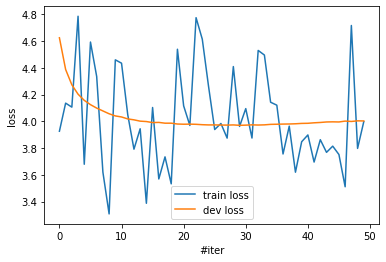

In [153]:
# y_train=np.array(y_train).reshape(1,len(y_train))
# print(y_train.T.shape)
# parameters = TrainSVM(X_train_extended,y_train.astype(int),X_dev_extended,y_dev.astype(int),X_test_extended,y_test.astype(int),0.01,0.01)
parameters = TrainSVM(X_train,y_train.astype(int),X_dev,y_dev.astype(int),0.01,0.01)

In [37]:
#Adding age and sex to the data :
X_train_extended=[]
for i in range(X_train.shape[0]):
    age_category = int(data_train['age'][i]/20)
    X_train_extended.append(np.concatenate(([1],X_train[i],[age_category]),axis=0))
    
X_train_extended = np.squeeze(np.array(X_train_extended))    
X_dev_extended=[]
for i in range(X_dev.shape[0]):
    age_category = int(data_train['age'][i+len(X_train)]/20)
    X_dev_extended.append(np.concatenate(([1],X_dev[i],[age_category]),axis=0))
    
X_dev_extended = np.squeeze(np.array(X_dev_extended))

X_test_extended=[]
for i in range(X_test.shape[0]):
    age_category = int(data_train['age'][i+len(X_train)+len(X_dev)]/20)
    X_test_extended.append(np.concatenate(([1],X_test[i],[age_category]),axis=0))

X_test_extended = np.squeeze(np.array(X_test_extended))

In [86]:
for i,group in enumerate(shrink_corpus):  
    if event[data_train['event'][i]] < 10:
        print('Event: {0:3d} , Reps of Event : {1:6f}'.format(data_train['event'][i],event[data_train['event'][i]]))
        for token in group:
            print('TOKEN:  {0:14s} ,Reps: {1:14f}'.format(token,words[token]))

        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

Event:  74 , Reps of Event : 4.000000
TOKEN:  CHEST          ,Reps:    4278.000000
TOKEN:  TIE            ,Reps:      74.000000
TOKEN:  RR             ,Reps:      13.000000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Event:  10 , Reps of Event : 2.000000
TOKEN:  INRING         ,Reps:       1.000000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Event:  74 , Reps of Event : 4.000000
TOKEN:  SUDDENONSET    ,Reps:       3.000000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Event:  30 , Reps of Event : 1.000000
TOKEN:  VOLT           ,Reps:      31.000000
TOKEN:  LIVE           ,Reps:      23.000000
TOKEN:  GROUNDED       ,Reps:       1.000000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Event:  56 , Reps of Event : 6.000000
TOKEN:  BIPAP          ,Reps:       2.000000
TOKEN:  40MINS         ,Reps:       2.000000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Event:  59 , Reps of Event : 4.000000
TOKEN:  DIFFUSE        ,Reps:      35.000000
TOKEN:  LIGHTNING      ,Reps:      14.000000
TOKEN:  RUCK           ,Reps:       5

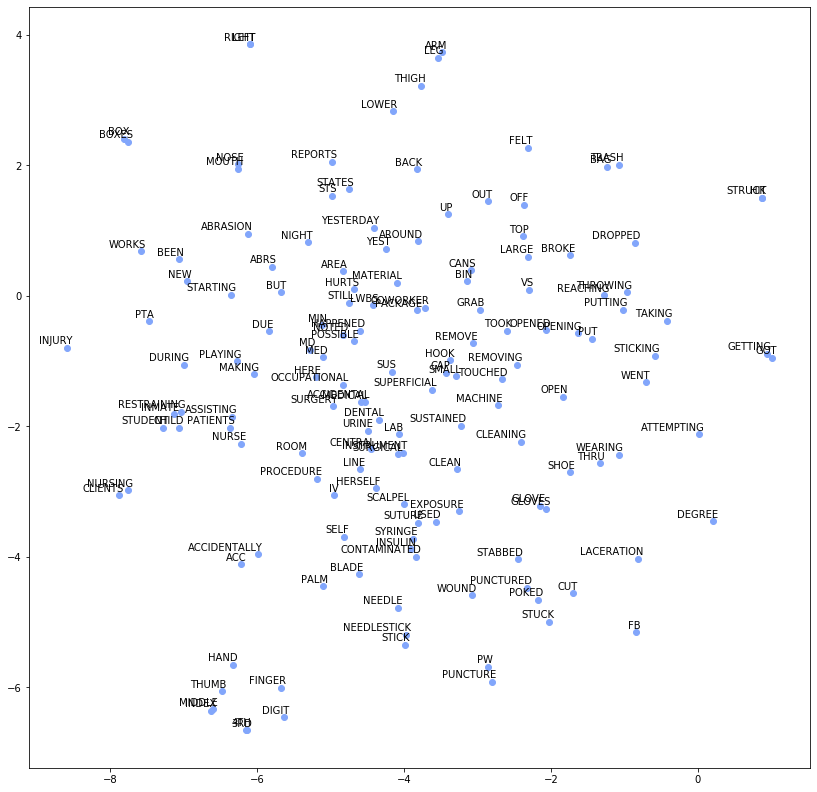

In [109]:

def cosine_distance(model, word,target_list , num) :
    cosine_dict ={}
    word_list = []
    a = model.wv[word]
    for item in target_list :
        if item != word :
            b = model.wv[item]
            cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
            cosine_dict[item] = cos_sim
    dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True) ## in Descedning order 
    for item in dist_sort:
        word_list.append((item[0], item[1]))
    return word_list[0:num]


def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,wMatrixSize), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.wv.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    pt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        pt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    pt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    pt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    pt.show()
    
    
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    
#     print(event.keys())
#     fig = pt.figure(figsize=(16, 16))
#     ax = fig.add_subplot(111)
    colors = pt.cm.coolwarm([(list(event.keys())[20]- np.mean(list(event.keys())))/list(event.keys())[20]])
#     i = 1
    for c,e in zip(colors,[list(event.keys())[20]]):
        for word in model.wv.vocab:
            if e in word_to_event[word]:
                tokens.append(model.wv[word])
                labels.append(word)
    
        tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
        new_values = tsne_model.fit_transform(tokens)

        x = []
        y = []
    #     print(new_values.get_params())
        for value in new_values:
    #         print(value)
            x.append(value[0])
            y.append(value[1])

        pt.figure(figsize=(14, 14))
        for i in range(len(x)):
    #         print( np.mean(list(word_to_event[labels[i]])))
#             pt.scatter(x[i],y[i],cmap=pt.cm.coolwarm(np.mean(list(word_to_event[labels[i]]))))
            pt.scatter(x[i],y[i],color=c)
            pt.annotate(labels[i],
                         xy=(x[i], y[i]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')
#         i = i + 1
#         pt.show()
        pt.savefig('Event20_TSNE_500.png')

    

# a = cosine_distance(model,'BURN',['OIL'],10)
# display_closestwords_tsnescatterplot(model, 'BURN')
# print(a)
tsne_plot(model)

In [101]:
def InitializeParameters(m,n_x,batch_size):
    """
    Initilaize weight matrix with method of     and bias b
    @param m : number of classes to be classified
    @param n_x: size of the word matrix 
    @param batch_size : batch size for each iteration 
    
    
    @return parameters : a dictionary with weight matrix W and b
    """
    
    
    W = np.random.randn(m,n_x)*0.01
#     W = [collections.defaultdict(float)]*m
#     b = np.zeros((m,1))
    
    parameters = {"W":W}
#                   "b" :b}
    return parameters

In [102]:
def Forward(parameters,X):
    """
    Perform forward transform 
    
    
    @param parameters : a dictionary with weight matrix W and b
    @param X : feature vector with size [batch_size,word Matrix size]
    
    
    @return Z 
    """
    W = parameters["W"]
#     b = parameters["b"]
    
        
#     Z= np.dot(W,X.T) + b
    Z= np.dot(W,X.T)
    
    return Z 
    

In [111]:
def UpdateWeights(parameters,Y,X,predicted_Y,eta,l):
    """
    Updates the parameters based on prediction
    
    @param parameters : a dictionary with keys W and b
    @param eta : step size
    @param l : regularization constant 
    @param Y : one-hot vector of true Y with size [batch_size, number of class classification]
    @param X : feature vector [bathc_size, Word matrix Size]
    @param predicted_Y : one-hot vector of predicted Y [number of class classification,batch size]
    
    @retrun updated W and b in parameters dictionary
    """
    W = parameters["W"]
#     b = parameters["b"]

    
    dW =  1/Y.shape[0]*(np.dot((predicted_Y-Y.T),X)) + l*W #last term is due to regularization 
#     dW =  1/Y.shape[0]*(np.dot((predicted_Y-Y.T),X)) + l*((W>=0)*1.0+(W<0)*-1.0)
    W -= eta*dW
#     b -= eta*1/Y.shape[0]*np.sum((predicted_Y-Y.T), axis=1, keepdims=True)
    
#     parameters = {"W" : W, "b" : b}
    parameters = {"W" : W}
    
    return parameters
    
    

In [112]:
def PredictionAccuracy(X,Y,parameters):
    """
    
    
    """
    W = parameters["W"]
#     b = parameters["b"]
    Z = np.zeros(Y.shape)
    error = np.zeros((Y.shape[1],1))
    errorM = 0
    freq = np.zeros((Y.shape[1],1))
#     Z= np.dot(W,X.T) + b
    Z= np.dot(W,X.T)
    predicted_Y = np.exp(Z)/np.sum(np.exp(Z), axis=0, keepdims=True)
    for i in range(Y.shape[0]):        
        freq[np.argmax(Y[i,:])] += 1
        if np.argmax(predicted_Y[:,i]) != np.argmax(Y[i,:]):
            error[np.argmax(Y[i,:])] += 1
            errorM += 1
        
    print(error/(freq+0.001))
    return errorM/Y.shape[0]

In [113]:
def Loss(Y,predicted_Y,W,l):
    
    loss = -1/Y.shape[0]*np.sum(Y.T*np.log(predicted_Y)) + l/2.*np.sum(np.dot(W.T,W))
#     loss = -1/Y.shape[0]*np.sum(Y.T*np.log(predicted_Y)) + l*np.sum(np.abs(W))
    
    
    
    return loss

In [114]:
def trainModel(X_train,Y_train,X_dev,Y_dev,eta = 0.005,l = 0.001, numIter=50,batch_size=512):
    """
    Trian model based on batch gardient descent. 
    
    """
    
    loss = []
    error =[]
    lossDev = []
    errorDev =[]
    parameters = InitializeParameters(Y_train.shape[1],X_train.shape[1],batch_size)
    for i in range(numIter):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        
        X_train = X_train[indices]
        Y_train = Y_train[indices]
        
        num_batches = X_train.shape[0]/batch_size
        for b in range(int(num_batches)):
            
            X = X_train[batch_size*b:min(batch_size*(b+1),X_train.shape[0]),:]
            Y = Y_train[batch_size*b:min(batch_size*(b+1),X_train.shape[0]),:]

            Z = Forward(parameters,X)
            predicted_Y = np.exp(Z)/np.sum(np.exp(Z), axis=0, keepdims=True)
            
            parameters = UpdateWeights(parameters,Y,X,predicted_Y,eta,l)
        print("iteration: {0}:".format(i))        
        error.append(PredictionAccuracy(X,Y,parameters))
        print("Train error :",error[-1])
        loss.append(Loss(Y,predicted_Y,parameters["W"],l))
        print('Train loss : ',Loss(Y,predicted_Y,parameters["W"],l))
        
        Z_dev = Forward(parameters,X_dev)
        predicted_Y_dev = np.exp(Z_dev)/np.sum(np.exp(Z_dev), axis=0, keepdims=True)
        errorDev.append(PredictionAccuracy(X_dev,Y_dev,parameters))
        print("Dev error :", errorDev[-1])
        lossDev.append(Loss(Y_dev,predicted_Y_dev,parameters["W"],l))
        print("Dev loss :", Loss(Y_dev,predicted_Y_dev,parameters["W"],l))
    pt.plot(range(numIter),loss,label='train loss')
    pt.plot(range(numIter),lossDev, label = 'dev loss')
        
    pt.ylabel('loss')
    pt.xlabel('#iter')
#     pt.plot(range(numIter),errorDev,range(numIter),error)
    
#     pt.xlabel('#iter')
#     pt.ylabel('error')
    pt.legend()
    pt.savefig('loss_LR_lemma_eta0p001_l0p001_bs512_L2_nf1000.png')
    
    return parameters

iteration: 0:
[[0.68353565]
 [0.37499531]
 [0.98460024]
 [0.97616723]
 [0.99996429]
 [0.99995652]
 [0.96425128]
 [0.99996774]
 [0.95648015]
 [0.99994445]
 [0.99985716]
 [0.99992308]
 [0.99983336]
 [0.9999091 ]
 [0.99987502]
 [0.99975006]
 [0.99980004]
 [0.99985716]
 [0.99985716]
 [0.99975006]
 [0.99975006]
 [0.99966678]
 [0.99983336]
 [0.99975006]
 [0.        ]
 [0.999001  ]
 [0.999001  ]
 [0.99950025]
 [0.        ]
 [0.999001  ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.999001  ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
Train error : 0.845703125
Train loss :  3.8569941845423084
[[0.65843278]
 [0.36952054]
 [0.96225146]
 [0.93835536]
 [0.9999989 ]
 [0.98887543]
 [0.98098324]
 [0.99639303]
 [0.97099088]
 [0.99999812]
 [0.99771982]
 [0.99743334]
 [0.99999693]
 [0.99999653]
 [0.9999963 ]
 [0.99999554]
 [0.99999342]
 [0.99999275]
 [

iteration: 6:
[[0.        ]
 [0.39560005]
 [0.99998113]
 [0.99997368]
 [0.99996296]
 [0.99997222]
 [0.99996429]
 [0.9999697 ]
 [0.99994445]
 [0.99994118]
 [0.99991667]
 [0.99993334]
 [0.99992308]
 [0.99990001]
 [0.99983336]
 [0.99966678]
 [0.99983336]
 [0.99950025]
 [0.999001  ]
 [0.999001  ]
 [0.99980004]
 [0.99983336]
 [0.99950025]
 [0.99950025]
 [0.99950025]
 [0.99980004]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.99950025]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.999001  ]
 [0.        ]
 [0.        ]]
Train error : 0.7421875
Train loss :  3.744090364451054
[[0.04438439]
 [0.41786136]
 [0.99999936]
 [0.99999914]
 [0.9999989 ]
 [0.99999889]
 [0.99999888]
 [0.9999988 ]
 [0.99999847]
 [0.99999812]
 [0.99999772]
 [0.99999744]
 [0.99999693]
 [0.99999653]
 [0.9999963 ]
 [0.99999554]
 [0.99999342]
 [0.99999275]
 [0.9

iteration: 12:
[[0.        ]
 [0.57470604]
 [0.99998305]
 [0.99997059]
 [0.99996667]
 [0.99995834]
 [0.99996   ]
 [0.99996552]
 [0.99994118]
 [0.99995238]
 [0.99994118]
 [0.99992858]
 [0.99992308]
 [0.9999091 ]
 [0.99990001]
 [0.99990001]
 [0.99987502]
 [0.99983336]
 [0.99975006]
 [0.99980004]
 [0.999001  ]
 [0.        ]
 [0.99950025]
 [0.99966678]
 [0.999001  ]
 [0.99966678]
 [0.999001  ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.999001  ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
Train error : 0.779296875
Train loss :  3.6493036171628814
[[0.00347356]
 [0.55223247]
 [0.99999936]
 [0.99999914]
 [0.9999989 ]
 [0.99999889]
 [0.99999888]
 [0.9999988 ]
 [0.99999847]
 [0.99999812]
 [0.99999772]
 [0.99999744]
 [0.99999693]
 [0.99999653]
 [0.9999963 ]
 [0.99999554]
 [0.99999342]
 [0.99999275]
 

iteration: 18:
[[0.        ]
 [0.56976082]
 [0.99997872]
 [0.99996552]
 [0.99996429]
 [0.99997143]
 [0.99996552]
 [0.99995652]
 [0.99995652]
 [0.99994445]
 [0.9999375 ]
 [0.99990001]
 [0.99990001]
 [0.9998889 ]
 [0.99985716]
 [0.9999091 ]
 [0.99983336]
 [0.99966678]
 [0.99975006]
 [0.99975006]
 [0.99975006]
 [0.99975006]
 [0.99950025]
 [0.999001  ]
 [0.99950025]
 [0.        ]
 [0.        ]
 [0.99950025]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.999001  ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
Train error : 0.736328125
Train loss :  3.5354191061751057
[[7.71902442e-04]
 [6.24743701e-01]
 [9.99999360e-01]
 [9.99999144e-01]
 [9.99998896e-01]
 [9.99998888e-01]
 [9.99998881e-01]
 [9.99998798e-01]
 [9.99998473e-01]
 [9.99998120e-01]
 [9.99997722e-01]
 [9.99997436e-01]
 [9.99996933e-01]
 [9.99996528e-01]
 

[[0.        ]
 [0.64932378]
 [0.99999936]
 [0.99999914]
 [0.9999989 ]
 [0.99999889]
 [0.99999888]
 [0.9999988 ]
 [0.99999847]
 [0.99999812]
 [0.99999772]
 [0.99999744]
 [0.99999693]
 [0.99999653]
 [0.9999963 ]
 [0.99999554]
 [0.99999342]
 [0.99999275]
 [0.9999902 ]
 [0.99998901]
 [0.99998876]
 [0.99998824]
 [0.99998701]
 [0.99998   ]
 [0.99997917]
 [0.99997368]
 [0.9999697 ]
 [0.99996552]
 [0.99990001]
 [0.99990001]
 [0.99983336]
 [0.99983336]
 [0.99980004]
 [0.99980004]
 [0.99980004]
 [0.99975006]
 [0.99966678]
 [0.99966678]
 [0.99950025]
 [0.99950025]
 [0.99950025]
 [0.999001  ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
Dev error : 0.7763721292331647
Dev loss : 3.482855953641184
iteration: 24:
[[0.        ]
 [0.67604682]
 [0.99998246]
 [0.99996429]
 [0.99996154]
 [0.99997368]
 [0.99997561]
 [0.99995834]
 [0.99995652]
 [0.99992858]
 [0.99994118]
 [0.99991667]
 [0.9999091 ]
 [0.99990001]
 [0.9999091 ]
 [0.99990001]
 [0.999001  ]
 [0.99975006]


[[0.        ]
 [0.65833648]
 [0.99999936]
 [0.99999914]
 [0.9999989 ]
 [0.99999889]
 [0.99999888]
 [0.9999988 ]
 [0.99999847]
 [0.99999812]
 [0.99999772]
 [0.99999744]
 [0.99999693]
 [0.99999653]
 [0.9999963 ]
 [0.99999554]
 [0.99999342]
 [0.99999275]
 [0.9999902 ]
 [0.99998901]
 [0.99998876]
 [0.99998824]
 [0.99998701]
 [0.99998   ]
 [0.99997917]
 [0.99997368]
 [0.9999697 ]
 [0.99996552]
 [0.99990001]
 [0.99990001]
 [0.99983336]
 [0.99983336]
 [0.99980004]
 [0.99980004]
 [0.99980004]
 [0.99975006]
 [0.99966678]
 [0.99966678]
 [0.99950025]
 [0.99950025]
 [0.99950025]
 [0.999001  ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
Dev error : 0.7777994031400026
Dev loss : 3.4107855623948473
iteration: 30:
[[0.        ]
 [0.61841292]
 [0.99998077]
 [0.99997826]
 [0.99996667]
 [0.99995652]
 [0.99995652]
 [0.99997297]
 [0.99992858]
 [0.99992858]
 [0.9999375 ]
 [0.9999375 ]
 [0.9999375 ]
 [0.99985716]
 [0.9998889 ]
 [0.9998889 ]
 [0.99966678]
 [0.99980004]

[[0.        ]
 [0.64235943]
 [0.99999936]
 [0.99999914]
 [0.9999989 ]
 [0.99999889]
 [0.99999888]
 [0.9999988 ]
 [0.99999847]
 [0.99999812]
 [0.99999772]
 [0.99999744]
 [0.99999693]
 [0.99999653]
 [0.9999963 ]
 [0.99999554]
 [0.99999342]
 [0.99999275]
 [0.9999902 ]
 [0.99998901]
 [0.99998876]
 [0.99998824]
 [0.99998701]
 [0.99998   ]
 [0.99997917]
 [0.99997368]
 [0.9999697 ]
 [0.99996552]
 [0.99990001]
 [0.99990001]
 [0.99983336]
 [0.99983336]
 [0.99980004]
 [0.99980004]
 [0.99980004]
 [0.99975006]
 [0.99966678]
 [0.99966678]
 [0.99950025]
 [0.99950025]
 [0.99950025]
 [0.999001  ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
Dev error : 0.775269235759699
Dev loss : 3.3484989650713035
iteration: 36:
[[0.        ]
 [0.59492918]
 [0.99997872]
 [0.99997368]
 [0.99995652]
 [0.99997619]
 [0.99996154]
 [0.99996296]
 [0.99996   ]
 [0.99994118]
 [0.99987502]
 [0.99992308]
 [0.9999091 ]
 [0.99990001]
 [0.9999091 ]
 [0.99990001]
 [0.99980004]
 [0.99950025]


[[0.        ]
 [0.60917632]
 [0.99999936]
 [0.99999914]
 [0.9999989 ]
 [0.99999889]
 [0.99999888]
 [0.9999988 ]
 [0.99999847]
 [0.99999812]
 [0.99999772]
 [0.99999744]
 [0.99999693]
 [0.99999653]
 [0.9999963 ]
 [0.99999554]
 [0.99999342]
 [0.99999275]
 [0.9999902 ]
 [0.99998901]
 [0.99998876]
 [0.99998824]
 [0.99998701]
 [0.99998   ]
 [0.99997917]
 [0.99997368]
 [0.9999697 ]
 [0.99996552]
 [0.99990001]
 [0.99990001]
 [0.99983336]
 [0.99983336]
 [0.99980004]
 [0.99980004]
 [0.99980004]
 [0.99975006]
 [0.99966678]
 [0.99966678]
 [0.99950025]
 [0.99950025]
 [0.99950025]
 [0.999001  ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
Dev error : 0.7700142727390684
Dev loss : 3.295161796076148
iteration: 42:
[[0.        ]
 [0.64705121]
 [0.99997619]
 [0.99997561]
 [0.9999697 ]
 [0.99997143]
 [0.99996429]
 [0.99995   ]
 [0.99993334]
 [0.99994737]
 [0.99992858]
 [0.9998889 ]
 [0.99992858]
 [0.99992858]
 [0.9998889 ]
 [0.99980004]
 [0.99980004]
 [0.99983336]


[[0.        ]
 [0.56493217]
 [0.99999936]
 [0.99999914]
 [0.9999989 ]
 [0.99999889]
 [0.99999888]
 [0.9999988 ]
 [0.99999847]
 [0.99999812]
 [0.99999772]
 [0.99999744]
 [0.99999693]
 [0.99999653]
 [0.9999963 ]
 [0.99999554]
 [0.99999342]
 [0.99999275]
 [0.9999902 ]
 [0.99998901]
 [0.99998876]
 [0.99998824]
 [0.99998701]
 [0.99998   ]
 [0.99997917]
 [0.99997368]
 [0.9999697 ]
 [0.99996552]
 [0.99990001]
 [0.99990001]
 [0.99983336]
 [0.99983336]
 [0.99980004]
 [0.99980004]
 [0.99980004]
 [0.99975006]
 [0.99966678]
 [0.99966678]
 [0.99950025]
 [0.99950025]
 [0.99950025]
 [0.999001  ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
Dev error : 0.7630076553782276
Dev loss : 3.249773543564489
iteration: 48:
[[0.        ]
 [0.62161322]
 [0.99998246]
 [0.99998   ]
 [0.99995834]
 [0.99997297]
 [0.99997619]
 [0.99995455]
 [0.99994737]
 [0.99994445]
 [0.99991667]
 [0.99966678]
 [0.99992308]
 [0.99975006]
 [0.99985716]
 [0.99985716]
 [0.99966678]
 [0.99975006]


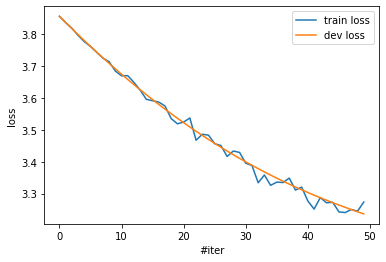

In [115]:
# print(X_dev_extended.shape)
# parameters = trainModel(X_train,Y_train,X_dev,Y_dev,0.01,0.1)
parameters = trainModel(X_train_extended,np.squeeze(Y_train),X_dev_extended,np.squeeze(Y_dev),0.001,0.001)

In [ ]:
data_test = pd.read_csv('/Users/Yassi/Documents/CS221/project/data/test.csv')
data_test.head()

In [148]:


corpus_test = []
words_test = collections.defaultdict(float)
for index,row in data_test.iterrows():
    phi = ExctractFeatures(row['text'],unused_words)
    t =[]
    for f in phi.keys():
        t.append(f)
        words_test[f] += 1
    corpus_test.append(t)
    
shrink_corpus_test = []
for i,group in enumerate(corpus):
    token_sorted = sorted(group, key = lambda x: words[x],reverse=True)
    selected_tokens = []
    for token in  token_sorted:
        if words[token] < event[data_train['event'][i]]: 
            selected_tokens.append(token)
            if len(selected_tokens) == 3:
                break
    if len(selected_tokens) == 0:
        selected_tokens = token_sorted[-3:]
                
    shrink_corpus_test.append(selected_tokens)
    
#test data set
model_test = Word2Vec(shrink_corpus_test, min_count = MinCount,  
                              size = wMatrixSize, window =10)
X_test= np.array([np.mean([model_test.wv[word] for word in lines if word in model_test.wv.vocab] or [np.zeros(wMatrixSize)], axis=0) 
                        for lines in shrink_corpus_test])
event_test = collections.defaultdict(int)
for e in data_test['event']:
    event_test[e] += 1
EVENT = sorted(event_test.items(), key=lambda kv: kv[1],reverse=True)    
    

In [91]:
rare_event = [56,74,59,10,30,29]
for i,e in enumerate(data_train['event']):
    if e in rare_event:
        print('event: ',e)
        print('description: ')
        print(data_train['text'][i])
        print('----------------------')
#event 56 : 'AIR','ANOXIA','DROWNED','CHOCKING','ASPIRATION','ESOPHAGUS'
#EVENT 74 : 'CHEST', 'SEIZURE'
#EVENT 59 : 'LIGHTNING','PRESSURE','VOMITTING'
#EVENT 10 : 'HAND','FINGER','SPRAIN'
#EVENT 30 : 'BURN'
#EVENT 29 : 'FIBULA'

event:  74
description: 
59YOM C O CHEST PAIN AFTER LIFTING RR TIE CHEST PAIN
----------------------
event:  10
description: 
51YOM PAIN TO L 5TH FINGER WHEN RESPONDING TO A SITUATION AT WORK AND A SITUATION BROKE OUT INRING FINGER  FINGER FX
----------------------
event:  74
description: 
ATYPICAL CHEST PAIN 33YOWM WHILE AT WORK WAS DOING LIFTING  HAD SUDDENONSET OF CHEST DISCOMFORT MAYBE A LITTLE NAUSEATED DRY HEAVES
----------------------
event:  30
description: 
37 YOM WORKING IN BUCKET TRUCK ON 7200 VOLT LIVE WIRE BURN FROM FIRE BALL WHEN LINE GROUNDED DX BURN ARM FACE NECK CHEST EARS
----------------------
event:  56
description: 
49YOM AT WORK AS FIREFIGHTER CHECKING NEW BIPAP MACHINE THAT WASNT WORKING WEARING IT 30 40MINS NOT ENOUGH AIR DX ALTERED MENTAL STATUS
----------------------
event:  59
description: 
40YOM AT WORK LEANING AGAINST THE OUTSIDE OF A BUILDING WHEN IT WAS ST RUCK BY LIGHTNING DIFFUSE MUSCLE ACHES AND TINGLING LIGHTNING STRIKE
----------------------
event:  

In [419]:
#medium_event
for i,e in enumerate(data_train['event']):
#     if event[e] > 10 and event[e] < 100:
    if event[e] > 100:
        print('event: ',e)
        print('description: ')
        print(data_train['text'][i])
        print('----------------------')

event:  62
description: 
57YOM WITH CONTUSION TO FACE AFTER STRIKING IT WITH A POST POUNDER WHILE SETTING A FENCE POST
----------------------
event:  42
description: 
A 45YOM FELL ON ARM WHILE WORKING HAD SLIPPED ON WATER FX WRIST
----------------------
event:  26
description: 
58YOM WITH CERVICAL STRAIN  BACK PAIN S P RESTRAINED TAXI DRIVER IN LOW SPEED REAR END MVC NO LOC NO AB DEPLOYED
----------------------
event:  60
description: 
33 YOM LAC TO HAND FROM A RAZOR KNIFE
----------------------
event:  71
description: 
53YOM AT WORK IN A WAREHOUSE DOING UNSPECIFIED LIFTING AND STRAINED LO WER BACK
----------------------
event:  62
description: 
31YOM AT A CLIENTS HOME TRIMMING A TREE WITH A CHAIN SAW AND THE SAW KICKED BACK HIT LOWER ARM LACERATION TO LOWER ARM
----------------------
event:  60
description: 
54 YO MALE CUT FINGER SHARPENING A KNIFE AT WORK DX RIGHT INDEX FINGERLACERATION B
----------------------
event:  71
description: 
36 YO M C O B L BACK PAIN SINCE FRI WORSE TODAY 

event:  60
description: 
28YOM AT WORK WAS SCRUBBING THE FLOOR OF A BOAT WITH A WIRE BRUSH WHEN A PIECE OF SUBJECT WENT INTO HAND AND FORMED AN ABSCESS DX ABSCESS
----------------------
event:  63
description: 
19 YOF PW TOFOOT WHEN STEPPED ON A NAIL
----------------------
event:  73
description: 
31 YOM DX ANKLE SPRAIN  S P POLICE OFFICER CHASING PERPETRATOR FELT  POP AT WORK
----------------------
event:  71
description: 
43YOM TO ED FOR NECK PAIN FROM LIFTING A LARGE BOX AT WORK AT THE SUBJECT  NECK PAIN
----------------------
event:  42
description: 
32YOF SLIPPED ON WET FLOOR DID PARTIAL SPLIT PAIN GROIN   DX GROIN STRAIN
----------------------
event:  73
description: 
33YOM AT WORK GOES UP AND DOWN A LADDER ALL DAY LONG AND DEVELOPED PAININ HIP DX HIP PAIN
----------------------
event:  55
description: 
28 YOF WAS AT WORK AND INVOLVED IN CPR AND NOTICE THERE WAS BLOOD ON  HER WRIST DX EXPOSURE TO BLOOD
----------------------
event:  43
description: 
42YOM STANDING ON A CRATE AT W

event:  42
description: 
50 YO F THIS AM 16 HRS AGO WAS AT WORK SITTING ON CHAIR WHEN CHAIR LEGS GAVE OUT WENT BACKWARDS INTO WALL DX MSK PAIN
----------------------
event:  42
description: 
35 YOF SLIPPED ON WET FLOOR AT WORK LAST WEEK AND FELL C O NECK  AND LOWER BACK PAIN DX CERVICAL STRAIN LUMBAR STRAIN
----------------------
event:  71
description: 
33 Y O MALE STATES WAS MOVING HEAVY PALLETS AT WORK AND INJURED  WRIST DX CONTUSION TO LEFT WRIST
----------------------
event:  63
description: 
44YM WORSENING H A DIZZINESS S P HITTING HEAD ON DUMPSTER  WORKX3 WENT TO OCC HEALTH SUTURED CONCUSSION
----------------------
event:  42
description: 
36YOF HAD A SLIP AND FALL AT WORK AND STRAINED RIGHT KNEE
----------------------
event:  26
description: 
30YOM AT WORK IN A SWAT TEAM VAN PASSENGER INVOLVED IN AN MVC SUSTAINEDA FINGER LACERATION
----------------------
event:  62
description: 
55 Y O M LACERATED FINGER WITH A BOX CUTTER AT WORK
----------------------
event:  71
description: 


event:  71
description: 
32YO HISP MALE AT WORK DOES LIFTING DEVELOPED CHEST PAIN    DX THORACIC STRAIN
----------------------
event:  63
description: 
29 YOF STATES HIT HEAD ON A DISPLAY SHELF AT WORK     DX SCALP CONTUSION
----------------------
event:  41
description: 
24YOM THAT SLIPPED WHILE COMING DOWN THE STAIRS AT WORK DENIES LOC  DX RT ANKLE SPRAIN
----------------------
event:  71
description: 
33 YOF CO PAIN IN THE RT SHOULDER AFTER REPETITIVE LIFTING AT WORK DX SPRAIN
----------------------
event:  60
description: 
44 YOF DX ANKLE SPRAIN  DUE TO HIT FOOT AT WORK 2 WEEKS AGO
----------------------
event:  11
description: 
49YOM W HAND LAC 2 2 BEING STABBED BY AN INDIVIDUAL W A SMOOTH EDGE KNIFE AT WORK
----------------------
event:  43
description: 
67 YOM FELL FROM LADDER AT WORK SUSTAINING A CUT TO THIGH AND LOWER  LEG DX LACERATION THIGH LOWER LEG
----------------------
event:  55
description: 
52YOF AT WORK SPRAYED FOR BUGS INHALED THE FUMES AND DEVELOPED RASH ANDITCHING

62 Y O M WORKS IN MANHOLES AND ALWAYS BUMPING FOREARM BUT NO SPECIFIC INJ DX CONTUSION ECCHYMOSIS FOREARM
----------------------
event:  63
description: 
40YOF LAC TO L 5TH DIGIT WHEN USING A MEAT SLICER AT WORK   DX FINGER LAC
----------------------
event:  55
description: 
30YOF ALLERGIC DERMATITIS HAS LATEX ALLERGY WEARS RUBBER BAND ON WRIST AT WORK
----------------------
event:  42
description: 
A 45YOM FELL LANDED ON KNEE OF STUDENT AT WORK CONTUSION TO RIB
----------------------
event:  73
description: 
30YM H O SLIPPED DISC WAS RUNNING  WORK WHEN SUDDENLY FELT TIGHTNESSIN HIS LOWER BACK PAIN LUMBAR DISC DZ
----------------------
event:  63
description: 
29YOM DEEP LAC LT SHIN ON PIECE OF SHARP METAL ON A MACHINE  WORK DX LAC LEG
----------------------
event:  62
description: 
26YOM AT WORK A PIECE OF EQUIPMENT FELL ON TOE  LAC TO TOE
----------------------
event:  71
description: 
38 YOF LUMBAR STRAIN S P HEAVY LIFTING AT WORK
----------------------
event:  43
description: 
37 Y

45 YOM BURN TO L FA ON GRILL AT WORK DX  2ND DEGREE BURN
----------------------
event:  26
description: 
52 YOF RESTRAINED DRIVER MVC DRIVING FOR WORK DX NECK STRAIN
----------------------
event:  62
description: 
45YM WAS SUBJECT 4 W AGO WHEN A FLYING OBJET HIT HIM IN THE FACE CAUSHED HIM TO FALL SHOULDER MS HAND CONTS
----------------------
event:  62
description: 
51 YO M THIS AM WORKING CONSTRUCITON C O BEING HIT IN THE HEAD W 2X4 DX SCALP LAC
----------------------
event:  62
description: 
30YF YTD  WORK A CLOCK FELL OFF WALL STRIKING HEAR HEAD NO LOC YET FEELS WEIRD  CONCUSSION
----------------------
event:  63
description: 
27YOM AT WORK USING A SLICER AND SUSTAINED A LACERATION TO LEFT FOURTH FINGER
----------------------
event:  53
description: 
24 YO FEMALE SPILLED BOILING WATER ON LEFT FOOT AT WORK DX SECOND DEGREE BURN LEFT FOOT
----------------------
event:  99
description: 
59 YOM HURT LLL AT WORK DX  FIB FX
----------------------
event:  73
description: 
R KNEE SPR 64YOW

59 YOM REACHING INTO GARBAGE BAG AND LT HAND PUNCTURED BELIEVES BY NAIL  HAND IS SWOLLEN AND TENDER TO TOUCH  DX  CELLULITIS OF LT HAND
----------------------
event:  73
description: 
52YOM SUST CERVICAL STRAIN WHEN HE TWISTED IT WHILE WORKING  CONSTRUCTION
----------------------
event:  42
description: 
46YOF AT WORK GETTING OFF THE BUS FELL INTO ANOTHER BUS HIT HEAD NO RECALL OF EVENTS R WRIST PX DX ACUTE HEAD TRAUMA NECK STRAIN WRIST STRAIN
----------------------
event:  71
description: 
42 YOF DISLOCATED SHOULDER LIFTING HEAVY FOOD WHILE CATERING
----------------------
event:  63
description: 
22YOF SUST LAC TO HAND WHEN SLICING HAM ON A SLICER WHILE WORKING IN THE DELI
----------------------
event:  42
description: 
41YOF PAIN TO KNEE S P SLIP AND FALL TWISTING KNEE WHEN TRYING TO SIT IN A CHAIR THAT SLIPPED OUT FROM UNDER PT DX KNEE PAIN
----------------------
event:  71
description: 
26YOM WAS MOVING UNSPECIFIED HEAVY OBJECT AT WORK AND FELT A PULL IN CHEST STRAINED CHEST MUSCLE

description: 
39YM ACC SUSTAINED A CUT ON THIGH BY TABLE VS CIRCULAR SAW  WORK  LAC
----------------------
event:  73
description: 
52YOF RT HIP PAIN DOWN TO KNEE POSTAL CARRIER AND WALKS A LOT SOME BACK PAIN DX TROCHANTERIC BURSITIS RT HIP
----------------------
event:  55
description: 
23 YOM SUSTAINED NEEDLE STICK INJURY THREW DIRTY GLOVE DX FINGER PUNCTURE
----------------------
event:  11
description: 
44YM WKS AS DDS WORKS WITH VIOLENT INMATES DURING A TACKLE DOWN SCRAPED WITH FINGER NAILS TO OCCIPIT HAND ABRS CONTS
----------------------
event:  62
description: 
18YOM PUTTING AWAY CLEAN KNIVES AT WORK ACCIDENTAL CUT HAND HAND LAC
----------------------
event:  62
description: 
30YOM W ABD HIP FLANK  BACK PAIN S P STRUCK BY AN INDUSTRIAL CEMENT CONCRETE FINISHER HE LOST CONTROL OF AT WORK
----------------------
event:  62
description: 
30Y0M HIT IN THE HEAD WITH A STEEL BEAM AT WORK HAS NECK PAIN   DX  NECK STRAIN  NO OTHER INFO AVAILABLE
----------------------
event:  55
descrip

51YOF PAIN TO L ELBOW WHEN BOOSTING A PT AND PT PULLED ARM DX ELBOW STRAIN
----------------------
event:  62
description: 
34 YOM C O FINGER PAIN AFTER ACC SHOOTING A NAIL INTO HIS FINGER WITH A NAIL GUN TODAY AT WORK DX REMOVAL FB  TRAUMA L MIDDLE FINGER
----------------------
event:  60
description: 
23 YOF W  LACERATION TO RT THUMB REPORTS CUT SITE WHILE AT WORK
----------------------
event:  62
description: 
25YOM WAS AT WORK AND SUSTAINED A FINGER LACERATION HANDLING A KNIFE
----------------------
event:  71
description: 
47YF WITH MID LOW BACK PAIN THAT BEGAN WHILE TX ING A PATIENT  WORK BACK PAIN
----------------------
event:  55
description: 
35 YF WAS CLEANING A SCALPEL AND CUT FINGER AT WORK DX FINGER LAC
----------------------
event:  73
description: 
38YOM REPORTS PT IS A TRUCK DRIVER AND DROVE 3700 MILES LAST WEEK C O RT UPPER BACK PAIN DX ACUTE BRONCHITIS ACUTE THORACIC STRAIN
----------------------
event:  60
description: 
23YOM WORKS IN CONSTRUCTION AND WAS DEMOLISHING 

event:  13
description: 
38YF PRURITIC RASH ON BUTTOCKSX1W H O SCABIES EXPO WHILE BABYSITTING SCABIES
----------------------
event:  71
description: 
30YOF STRAINED NECK LIFTING LUGGAGE AT WORK
----------------------
event:  60
description: 
34YOM ANKLE CT HIT ANKLE  WORK
----------------------
event:  42
description: 
59YOM SLIPPED AND FELL AT WORK HITTING HIS ELBOW ON UNKNOWN SURFACE BURSITIS OLECRANON
----------------------
event:  13
description: 
38YOM WAS TRYING TO CORRAL A GROUP OF STRAYS DOGS AT WORK ONE OF THEM BIT HIM ON HIS HANDS DX  DOG BITES TO B L HANDS PUNCTURE WOUNDS
----------------------
event:  53
description: 
37YM WORKING UNDER A TRUCK THE TORCH FELL ONTO HIS ARM   BURN
----------------------
event:  71
description: 
30YOF AT WORK DOING UNSPECIFIED LIFTING AND STRAINED LOWER BACK
----------------------
event:  99
description: 
48YOM SMALL BLISTERS ON ARM WHEN DOING WORK ON SIDE OF ROADWAY   DENIES SOB  DERMATITIS CONTACT
----------------------
event:  62
descriptio

35 YOM TWISTED PIECE OF WOOD AT WORK HURT WRIST DX WRIST STRAIN
----------------------
event:  71
description: 
57YOF UPPER SHOULDER BACKPAIN AFTER MOVING SEVERAL HEAVY BOXES AT WORK DX LOWBACKPAIN
----------------------
event:  26
description: 
39 YM UNRESTRAINED DRIVER OF SUBJECT BUS INJURED IN MVA DX BACK PAIN
----------------------
event:  55
description: 
29YF ACC GOT STUCK C THE NEEDLE WHILE PLAYING CENTRAL LINE    PW NEEDLE STICK
----------------------
event:  55
description: 
30YOM INHALENT IRRITANT EXPOSED TO HIGHER LEVELS OF OZONE AT WORK THEN MORMAL BECAME DIZZY
----------------------
event:  62
description: 
49 YOF WITH CONTUSION ON RIGHT FOOT S P DROPPING A COFFE MACHINE ON SITE WHILE AT WORK
----------------------
event:  13
description: 
29YOM WAS STUNG BY BEE COUPLE TIMES  C O SOB SWOLLEN LIPSDX ACUTE ANAPHYLAXIS  WORK
----------------------
event:  62
description: 
27YOM HEAD INJURY 75 CRANE FELL ON PT S HEAD  WORK FOR A STAFFING AGENCY  A FACTORY
---------------------

description: 
34YOM STRAINED LOWER BACK LIFTING A HEAVY OBJECT AT WORK
----------------------
event:  64
description: 
26YOM WITH LACERATION TO FINGER PT S FINGER WAS CAUGHT BETWEEN 2 4X4S AT WORK DX LACERATION
----------------------
event:  55
description: 
33YM LANDSCAPER FOR LIVING C O RASH ON THE ARM THAT HE NOTICED AFTER SHOWER YTD RASH
----------------------
event:  55
description: 
50 YOM TRUCK DRIVER PASSED OUT LANDING ON A TABLE REPORTS FEELING HIGH FROM FUMES OF AN ADHESIVE HE IS TRANSPORTING DX TOX INHALATION
----------------------
event:  55
description: 
42YOF WITH BLOOD EXPOSURE TO HAND WITH PRE EXISTING LAC AT WORK
----------------------
event:  55
description: 
23 YOF RESPIRATORY THERAPIST REPORTS GETTING SUBJECT IN HER RT EYE NOW C O RT EYE PAIN DX CORNEAL ABRASION
----------------------
event:  73
description: 
39 YO M C O LOWER BACK PAIN FOR SEVERAL YEARS STATES DRIVES A TAXI FOR A LIVING DX LOW BACK PAIN
----------------------
event:  53
description: 
39 YOM HAD SYN

----------------------
event:  71
description: 
51YOM C O FLANK PAIN FOR 2 WKS WORKS AT AIRPORT DOING HEAVY LIFTING DX FLANK MUSCLE STRAIN
----------------------
event:  42
description: 
62 YOF FELL ON FLOOR AND STRAINED KNEE AT WORK
----------------------
event:  71
description: 
22YM C O INTERSCAPULAR PAIN WHICH WORSE WITH MOVEMENTX2WKS WORKS LIFTING 5GL BOTTLES OF WATER MS
----------------------
event:  55
description: 
30YM ACC STUCK RT MIDDLE FINGER WITH A USED NEEDLE  WORK    PW NEEDLE STICK
----------------------
event:  42
description: 
30YOM FELL CLEARING BRUSH LAC LT HAND  DX HAND LAC
----------------------
event:  62
description: 
38YOF WITH CONTUSION TO FOOT FROM FALLING CHAIR
----------------------
event:  73
description: 
LUMBOSACRAL STR 37YOFW L SIDED SI JOINT PAIN WORSE LAST 5 DAYS NO ASSOCIATED WEAKNESS BUT WORKS IN A POSITION WHERE SHE STANDS MOST OF DAY
----------------------
event:  71
description: 
32YOF TWISTED WRIST WHILE PICKING UP A CASE OF POP CANS DX STRAIN W

----------------------
event:  71
description: 
33YOM WAS LIFTING BAGS OF CONCRETE AT WORK AND INJURED LW BACK DX BACK STRAIN
----------------------
event:  70
description: 
27YOF AT WORK DOES REPETITIVE MOTION ALL DAY LONG AND DEVELOPE SEVERE PAIN IN WRIST CARPAL TUNNEL SYNDROME
----------------------
event:  62
description: 
61YOF WITH FINGER LACERATION BY SCISSORS AT WORK    DX LACERATION
----------------------
event:  13
description: 
41YOF W INSECT BITE STING AT WORK IN STOCK ROOM AT SUBJECT MOVING BOXESBITTEN TO R UPPER ARM DX ACUTE ALLERGIC RXN TO INSECT STING MULT STINGS
----------------------
event:  62
description: 
27YF HAIR DRESSER WAS USING NEW PAIR OF SCISSORS TO CUT HAIR ACC CAUGHT FINGER  LAC
----------------------
event:  13
description: 
44YOM AT WORK ROLLED BY A HORSE IS A STUNT MAN C O L ANKLE R KNEE PAIN HORSE FELL INTO PT  ROLLED UP ONTO LEGS PELVIS ABD DX FOOT SPRAIN
----------------------
event:  60
description: 
A 62YOM WAS OPENING LATCH ON CEILING OF BUS AND C

event:  62
description: 
45 YOM CONSTRUCTION WORKER STATES A PIECE OF WOOD FELL ON HIS HEAD WHILE AT WORK DX SCALP LACERATION
----------------------
event:  55
description: 
25 YOF C O RASH AND WONDS TO HAND S P WEARING GLOVES AT WORK AT NURSINGHOME DX RASH TO RIGHT HAND WOUNDS TO RIGHT HAND
----------------------
event:  71
description: 
21 Y O M LUMBAR STRAIN LIFTING ROCKS AT WORK
----------------------
event:  52
description: 
34YOM WAS WELDING AT WORK WHILE WEARING JUST SUN GLASSES AND DEVELOPED PAIN IN EYES UV KERATINITIS
----------------------
event:  64
description: 
56YM ACC GOT HAND CAUGHT IN A PRESS MACHINE  WORK     LAC
----------------------
event:  63
description: 
54 YOF SPRAINED LT 2ND FINGER S P UNLOADING CLOTHES FROM WASHING MACHINE  FINGER HIT MACHINE  BENT BACKWARD  WORK YESTERDAY
----------------------
event:  41
description: 
52 YO M C O RT ANKLE PAIN AT WORK ACCIDENTALLY SLIPPED INVERTED ANKLE DX ANKLE KNEE SPRAIN
----------------------
event:  27
description: 
31

----------------------
event:  70
description: 
36 YOM WORKS AS A COOK AND SAYS HE USES HIS R SHOULDER A LOT TO DO HIS JOB AFTER WORK PT FELT A LOT OF PAIN DX  SHOULDER PAIN
----------------------
event:  71
description: 
30YOM SUST LOW BACK STRAIN AFTER HOLDING A JACK HAMMER WEIRDLY AT WORK
----------------------
event:  64
description: 
27YOM WAS PICKING UP BASIN FRAME  WORK GOT FINGERS CAUGHT BETWEEN GRATE  FRAME DX HAND LAC
----------------------
event:  71
description: 
24YOM INGUINAL HERNIA DEVELOPED ABDOMINAL PAIN WHILE LIFTING AT WORK
----------------------
event:  62
description: 
40 Y O F LACERATED HAND WITH A KNIFE CUTTING HAM FOR A PATIENT
----------------------
event:  62
description: 
30 YOF CUTTING ROAST BEEF  KNIFE SLIPPED  CUT LEFT THUMB  WORK DX LAC DIGIT LAC REPAIR
----------------------
event:  42
description: 
54YOF WITH ANKLE SPRAIN AFTER FALLING AT WORK DX SPRAIN
----------------------
event:  71
description: 
21YOM WITH CHEST WALL PAIN ONSET AFTER LIFTING HEAVY 

KeyboardInterrupt: 

In [26]:
np.random.randint(1,6,1)

array([4])

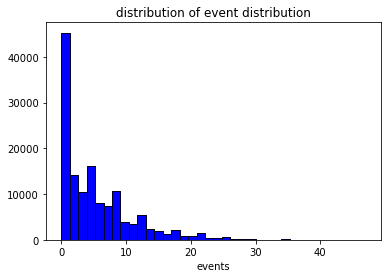

In [132]:
import seaborn as sns
normalized = np.zeros((len(EVENT),1))
for i,e in enumerate(EVENT):
    normalized[i] = e[1]/len(data_train)
    
pt.hist(y_train, color = 'blue', edgecolor = 'black',bins=int(180/5))

# seaborn histogram
sns.distplot(y_train, hist=True, kde=False, color = 'blue',bins=int(180/5),
             hist_kws={'edgecolor':'black'})
# Add labels
pt.title('distribution of event distribution')
pt.xlabel('events')
pt.savefig('data_dist.png')